<a href="https://colab.research.google.com/github/Lilo-Denise/1710-hw4-Lilo-Denise/blob/main/gpt_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-10-06 00:11:11--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-10-06 00:11:11 (56.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [20]:
# Use my own corpus instead of Shakespeare
path = "/content/the_great_gatsby.txt"

with open(path, "r", encoding="utf-8", errors="ignore") as f:
    text = f.read()

print("Loaded chars:", len(text))
print(text[:500])  # quick preview


Loaded chars: 1602
The Great Gatsby
by F. Scott Fitzgerald (1925)

Chapter 1
In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.
"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven't had the advantages that you've had."

He didn't say any more but we've always been unusually communicative in a reserved way, and I understood that he meant a great deal more than that.
In consequence, I'm 


In [3]:
# read it in to inspect it
#with open('input.txt', 'r', encoding='utf-8') as f:
 #   text = f.read()

In [21]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1602


In [22]:
# let's look at the first 1000 characters
print(text[:1000])

The Great Gatsby
by F. Scott Fitzgerald (1925)

Chapter 1
In my younger and more vulnerable years my father gave me some advice that I've been turning over in my mind ever since.
"Whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven't had the advantages that you've had."

He didn't say any more but we've always been unusually communicative in a reserved way, and I understood that he meant a great deal more than that.
In consequence, I'm inclined to reserve all judgments, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores.
The abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college I was unjustly accused of being a politician, because I was privy to the secret griefs of wild, unknown men.
Most of the confidences were unsought—frequently I have feigned sleep, preoccupation, or a hostile lev

In [23]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 "'(),-.1259;CEFGHIMRSTW[]abcdefghijklmnopqrstuvwxyz—
54


In [24]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[34, 35, 35, 1, 46, 34, 31, 44, 31]
hii there


In [25]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1602]) torch.int64
tensor([23, 34, 31,  1, 17, 44, 31, 27, 46,  1, 17, 27, 46, 45, 28, 51,  0, 28,
        51,  1, 16,  8,  1, 22, 29, 41, 46, 46,  1, 16, 35, 46, 52, 33, 31, 44,
        27, 38, 30,  1,  4,  9, 12, 10, 11,  5,  0,  0, 14, 34, 27, 42, 46, 31,
        44,  1,  9,  0, 19, 40,  1, 39, 51,  1, 51, 41, 47, 40, 33, 31, 44,  1,
        27, 40, 30,  1, 39, 41, 44, 31,  1, 48, 47, 38, 40, 31, 44, 27, 28, 38,
        31,  1, 51, 31, 27, 44, 45,  1, 39, 51,  1, 32, 27, 46, 34, 31, 44,  1,
        33, 27, 48, 31,  1, 39, 31,  1, 45, 41, 39, 31,  1, 27, 30, 48, 35, 29,
        31,  1, 46, 34, 27, 46,  1, 19,  3, 48, 31,  1, 28, 31, 31, 40,  1, 46,
        47, 44, 40, 35, 40, 33,  1, 41, 48, 31, 44,  1, 35, 40,  1, 39, 51,  1,
        39, 35, 40, 30,  1, 31, 48, 31, 44,  1, 45, 35, 40, 29, 31,  8,  0,  2,
        24, 34, 31, 40, 31, 48, 31, 44,  1, 51, 41, 47,  1, 32, 31, 31, 38,  1,
        38, 35, 37, 31,  1, 29, 44, 35, 46, 35, 29, 35, 52, 35, 40, 33,  1, 27,
        4

In [26]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [27]:
block_size = 8
train_data[:block_size+1]

tensor([23, 34, 31,  1, 17, 44, 31, 27, 46])

In [28]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([23]) the target: 34
when input is tensor([23, 34]) the target: 31
when input is tensor([23, 34, 31]) the target: 1
when input is tensor([23, 34, 31,  1]) the target: 17
when input is tensor([23, 34, 31,  1, 17]) the target: 44
when input is tensor([23, 34, 31,  1, 17, 44]) the target: 31
when input is tensor([23, 34, 31,  1, 17, 44, 31]) the target: 27
when input is tensor([23, 34, 31,  1, 17, 44, 31, 27]) the target: 46


In [29]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[47, 40, 45, 41, 47, 33, 34, 46],
        [39,  6,  1, 27, 44, 31,  1, 47],
        [33, 39, 31, 40, 46, 45,  6,  1],
        [ 1, 34, 41, 45, 46, 35, 38, 31]])
targets:
torch.Size([4, 8])
tensor([[40, 45, 41, 47, 33, 34, 46, 53],
        [ 6,  1, 27, 44, 31,  1, 47, 45],
        [39, 31, 40, 46, 45,  6,  1, 27],
        [34, 41, 45, 46, 35, 38, 31,  1]])
----
when input is [47] the target: 40
when input is [47, 40] the target: 45
when input is [47, 40, 45] the target: 41
when input is [47, 40, 45, 41] the target: 47
when input is [47, 40, 45, 41, 47] the target: 33
when input is [47, 40, 45, 41, 47, 33] the target: 34
when input is [47, 40, 45, 41, 47, 33, 34] the target: 46
when input is [47, 40, 45, 41, 47, 33, 34, 46] the target: 53
when input is [39] the target: 6
when input is [39, 6] the target: 1
when input is [39, 6, 1] the target: 27
when input is [39, 6, 1, 27] the target: 44
when input is [39, 6, 1, 27, 44] the target: 31
when input is [39

In [30]:
print(xb) # our input to the transformer

tensor([[47, 40, 45, 41, 47, 33, 34, 46],
        [39,  6,  1, 27, 44, 31,  1, 47],
        [33, 39, 31, 40, 46, 45,  6,  1],
        [ 1, 34, 41, 45, 46, 35, 38, 31]])


In [31]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 54])
tensor(4.2146, grad_fn=<NllLossBackward0>)

MmCFGWGgWo)heciuxjf)xl2 (qmhi-ore2t[' ]2auot9)—z(jR
1Mo—h—WeHwdMrFfx(m F(y]C;TW2quz'TW5ot
)(HSlmqH—9


In [15]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
#batch_size = 32
#for steps in range(100): # increase number of steps for good results...

    # sample a batch of data
    #xb, yb = get_batch('train')

    # evaluate the loss
    #logits, loss = m(xb, yb)
    #optimizer.zero_grad(set_to_none=True)
    #loss.backward()
    #optimizer.step()

#print(loss.item())


4.65630578994751


2.6574454307556152


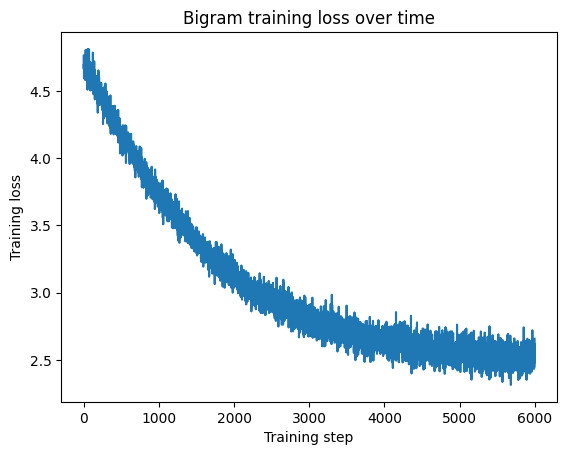

In [16]:
import matplotlib.pyplot as plt
losses = []

batch_size = 32
for steps in range(6000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

print(loss.item())

plt.plot(range(len(losses)), losses)
plt.xlabel("Training step")
plt.ylabel("Training loss")
plt.title("Bigram training loss over time")
plt.show()

4.474192142486572


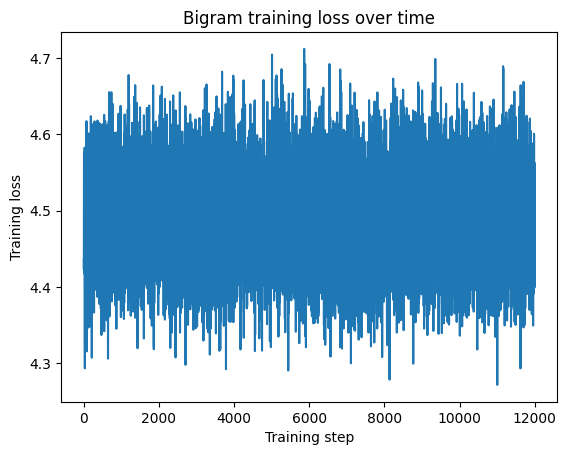

In [32]:
import matplotlib.pyplot as plt
losses = []

batch_size = 32
for steps in range(12000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

print(loss.item())

plt.plot(range(len(losses)), losses)
plt.xlabel("Training step")
plt.ylabel("Training loss")
plt.title("Bigram training loss over time")
plt.show()

In [33]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Epivibph5S " ('—,jvww"]yF-q5s2.;2..9hT'gnfxF;qi)n5ajnwt—t;x)l;tT)—FCyEsFzrbCy—,—.)xFSff5S—IciIxC1zfzgmnE[HkhT[c1dynw-qGnvzgd.—bpms
e—92xeecFvMjE1lsjWGopTIyCs.udGsi"cdMaCfr)xan"d;iiGE1Mso(2gmz
—Wdx5eMIkyiiCyEnwdG.n)'5Twd5—Wd—WuiuIH,'s2M-dc1dndGs—h)
xhFGr-u.zgTwm2M—c-. vlo
euyIgmczWIGg1wdxdt;q-5M
en1dGg—z(2Hy] -p
bksmalvcMh—ke
FSksWGdGTsjGnn(Tg'd—,1GoHqr)—.tMjotbz-pmzubxln(cxEnE-"GTW—ISMFCyS-q5vHEhu(mc[Ipg-mz-M"jMC)— .9GdWmC;]—9GfyC;29GISpSSF'FzC1dGS—h['-qr])ToG9veT'fvfi;z(b'll
ee)—.v
eHdGHkRWqiGe


## The mathematical trick in self-attention

In [34]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [35]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [36]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [37]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

False

In [38]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


False

In [39]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [40]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [41]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [42]:
k.var()

tensor(1.0449)

In [43]:
q.var()

tensor(1.0700)

In [44]:
wei.var()

tensor(1.0918)

In [45]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [46]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [47]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [48]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [49]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

In [50]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [52]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

with open('/content/the_great_gatsby.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.20831 M parameters
step 0: train loss 4.1063, val loss 4.1490
step 100: train loss 2.3965, val loss 3.0048
step 200: train loss 2.1376, val loss 3.1919
step 300: train loss 1.7557, val loss 3.4047
step 400: train loss 1.1604, val loss 3.9219
step 500: train loss 0.6734, val loss 4.3598
step 600: train loss 0.4049, val loss 4.8173
step 700: train loss 0.3247, val loss 5.1559
step 800: train loss 0.2759, val loss 5.6437
step 900: train loss 0.2578, val loss 5.6152
step 1000: train loss 0.2298, val loss 5.9897
step 1100: train loss 0.2146, val loss 5.9903
step 1200: train loss 0.2008, val loss 6.1626
step 1300: train loss 0.1994, val loss 6.2597
step 1400: train loss 0.1978, val loss 6.4065
step 1500: train loss 0.1854, val loss 6.3917
step 1600: train loss 0.1922, val loss 6.6338
step 1700: train loss 0.1923, val loss 6.5861
step 1800: train loss 0.1789, val loss 6.6856
step 1900: train loss 0.1773, val loss 6.6796
step 2000: train loss 0.1724, val loss 6.6667
step 2100: train loss 0.1